# Demo Workflow

First step, load the data 

In [223]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from energy_ml.data_loader import MachineDataLoader

loader = MachineDataLoader("../data/raw/Datadump.txt")

df = loader.load_data()
df_clean = loader.preprocess('ffill')

df_clean.head()


g:\My Drive\Documentos Juan Felipe\Technical Assessment\energy_ml_project\energy_ml\data_loader.py:38: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[self.energy_col] = df[self.energy_col].fillna(method="ffill")


,timestamp,value
0,2025-05-11 07:08:49.154,25.96
1,2025-05-11 07:08:49.413,26.21
2,2025-05-11 07:08:49.672,25.99
3,2025-05-11 07:08:49.931,25.83
4,2025-05-11 07:08:52.017,26.23


In [224]:
df_clean

,timestamp,value
0,2025-05-11 07:08:49.154,25.96000
1,2025-05-11 07:08:49.413,26.21000
2,2025-05-11 07:08:49.672,25.99000
3,2025-05-11 07:08:49.931,25.83000
4,2025-05-11 07:08:52.017,26.23000
...,...,...
197221,2025-05-12 08:08:45.874,44.79000
197222,2025-05-12 08:08:48.206,68.00000
197223,2025-05-12 08:08:48.465,71.90000
197224,2025-05-12 08:08:48.724,74.51000


In [225]:
# Estadísticas básicas
df_clean["value"].describe()


count    196886.000000
mean         37.953831
std          29.295578
min           0.789999
25%          26.100000
50%          26.240000
75%          26.550000
max         369.780000
Name: value, dtype: float64

In [226]:
Q1 = df_clean["value"].quantile(0.25)
Q2 = df_clean["value"].quantile(0.50)
Q3 = df_clean["value"].quantile(0.75)
IQR = Q3 - Q1

lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 * IQR

print(f"Q1: {Q1:.2f}, Q2 (mediana): {Q2:.2f}, Q3: {Q3:.2f}")
print(f"Límite inferior (outliers): {lim_inf:.2f}")
print(f"Límite superior (outliers): {lim_sup:.2f}")


Q1: 26.10, Q2 (mediana): 26.24, Q3: 26.55
Límite inferior (outliers): 25.43
Límite superior (outliers): 27.23


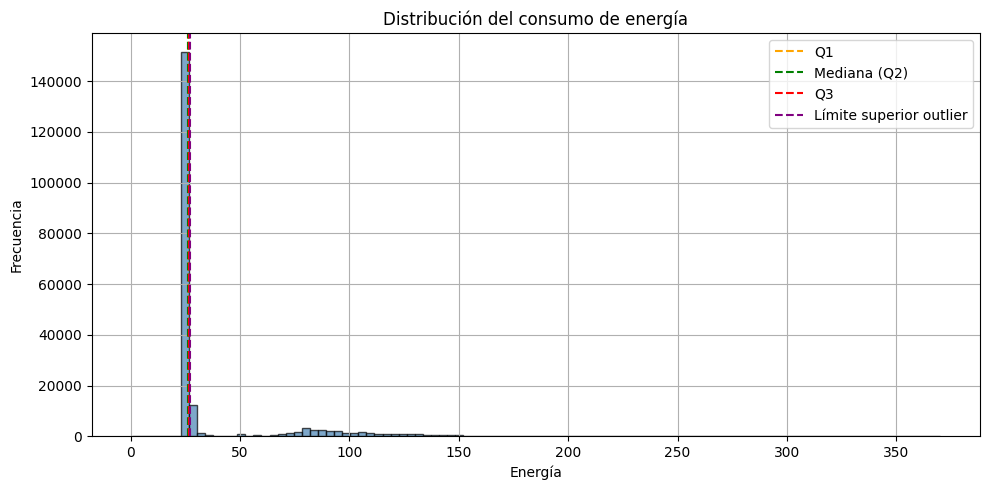

In [227]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df_clean["value"], bins=100, alpha=0.7, color='steelblue', edgecolor='k')
plt.axvline(Q1, color='orange', linestyle='--', label="Q1")
plt.axvline(Q2, color='green', linestyle='--', label="Mediana (Q2)")
plt.axvline(Q3, color='red', linestyle='--', label="Q3")
plt.axvline(lim_sup, color='purple', linestyle='--', label="Límite superior outlier")
plt.title("Distribución del consumo de energía")
plt.xlabel("Energía")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


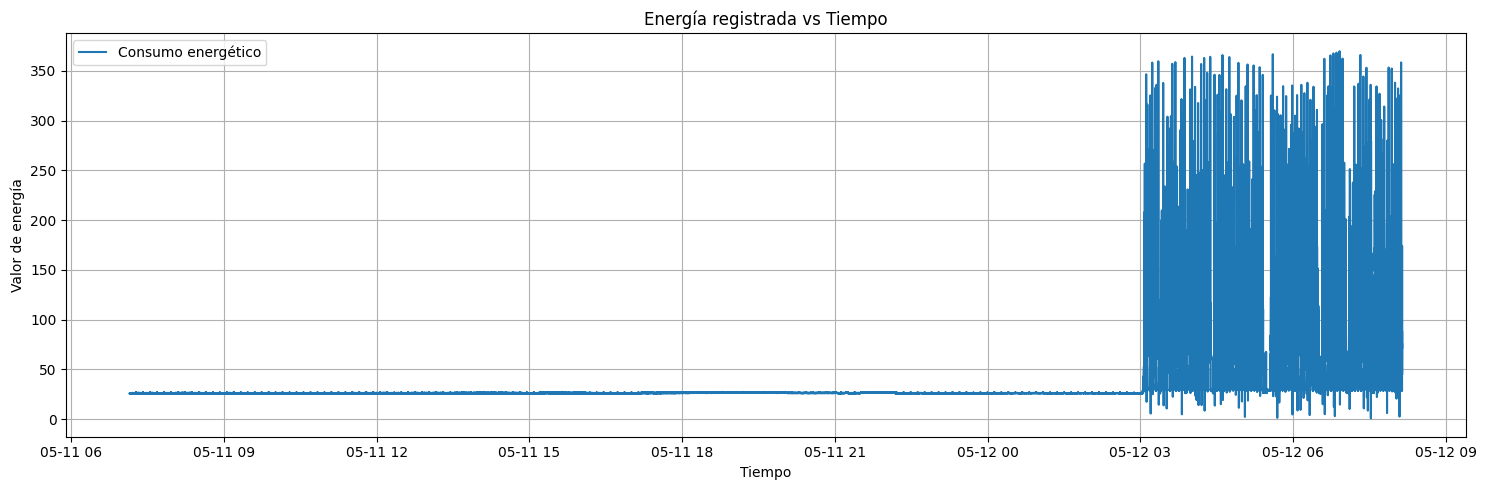

In [228]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(df_clean["timestamp"], df_clean["value"], label="Consumo energético")
plt.xlabel("Tiempo")
plt.ylabel("Valor de energía")
plt.title("Energía registrada vs Tiempo")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


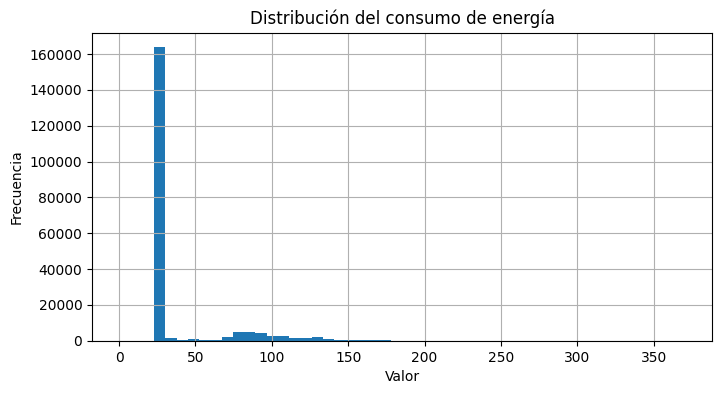

In [229]:
df_clean["value"].hist(bins=50, figsize=(8, 4))
plt.title("Distribución del consumo de energía")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()


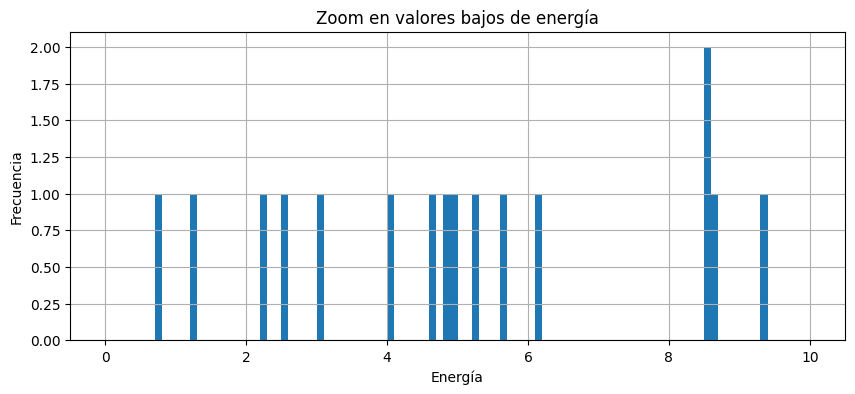

In [230]:
df_clean["value"].hist(bins=100, figsize=(10, 4), range=(0, 10))
plt.title("Zoom en valores bajos de energía")
plt.xlabel("Energía")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()


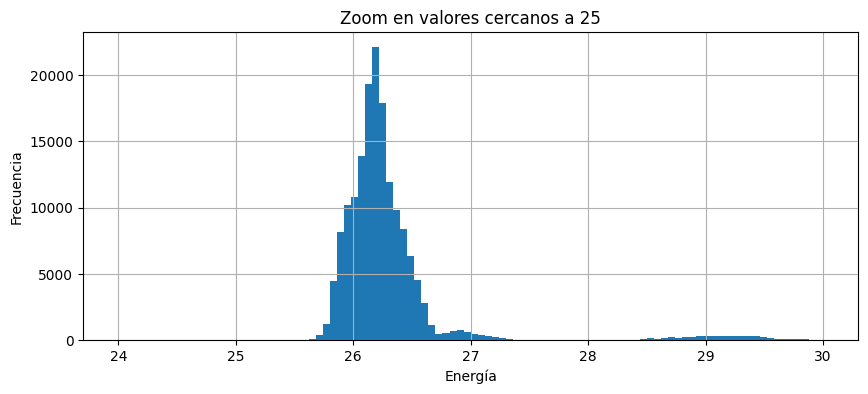

In [231]:
df_clean["value"].hist(bins=100, figsize=(10, 4), range=(24, 30))
plt.title("Zoom en valores cercanos a 25")
plt.xlabel("Energía")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()


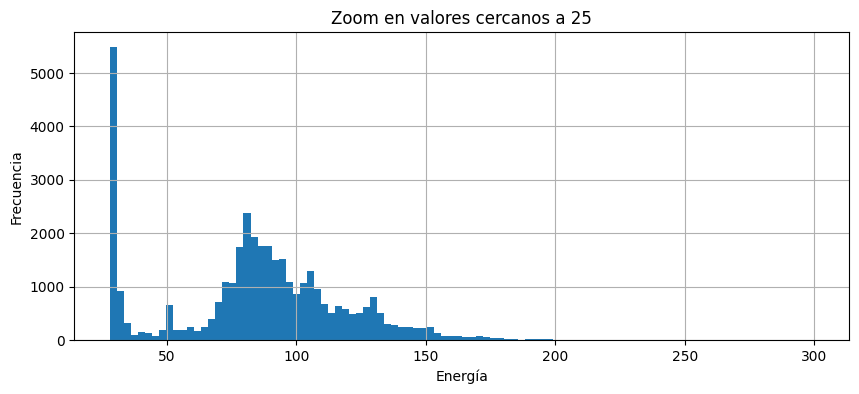

In [232]:
df_clean["value"].hist(bins=100, figsize=(10, 4), range=(28, 300))
plt.title("Zoom en valores cercanos a 25")
plt.xlabel("Energía")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

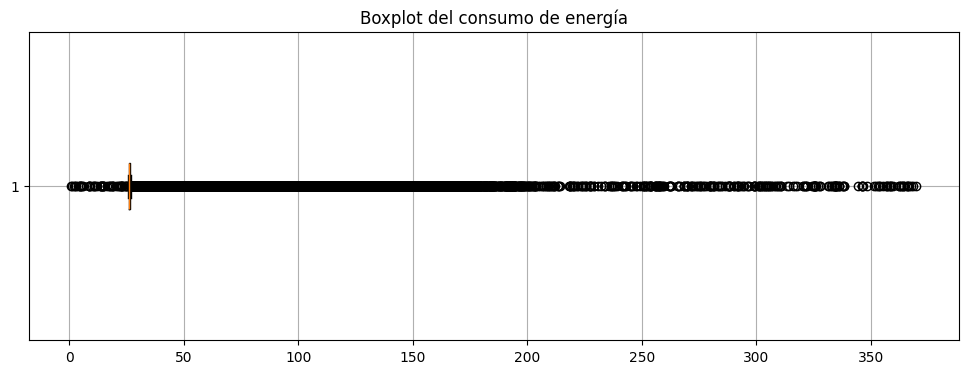

In [233]:
plt.figure(figsize=(12, 4))
plt.boxplot(df_clean["value"], vert=False)
plt.title("Boxplot del consumo de energía")
plt.grid(True)
plt.show()


C:\Users\ingju\AppData\Local\Temp\ipykernel_41240\2616360105.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df_clean.set_index("timestamp").resample("1T").mean()  # cada minuto


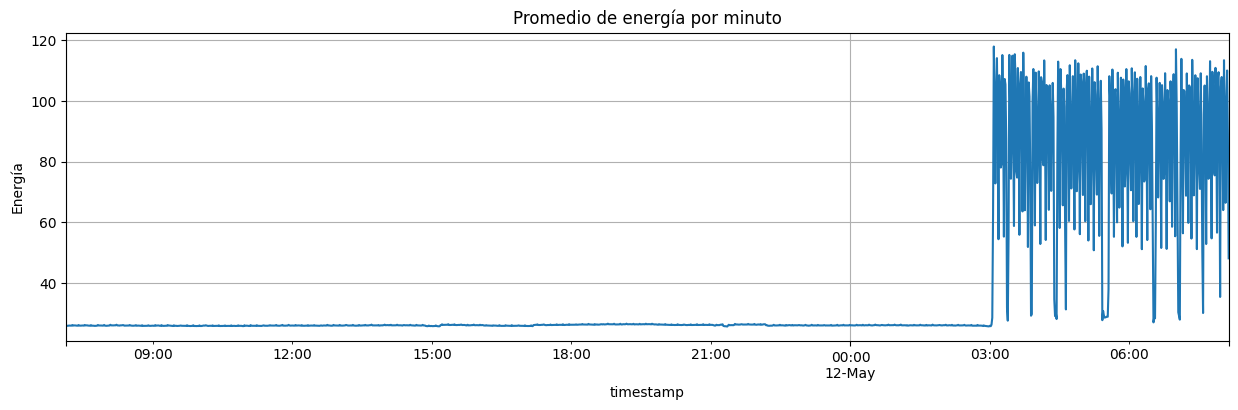

In [234]:
df_resampled = df_clean.set_index("timestamp").resample("1T").mean()  # cada minuto
df_resampled.plot(figsize=(15, 4), legend=False)
plt.title("Promedio de energía por minuto")
plt.ylabel("Energía")
plt.grid(True)
plt.show()


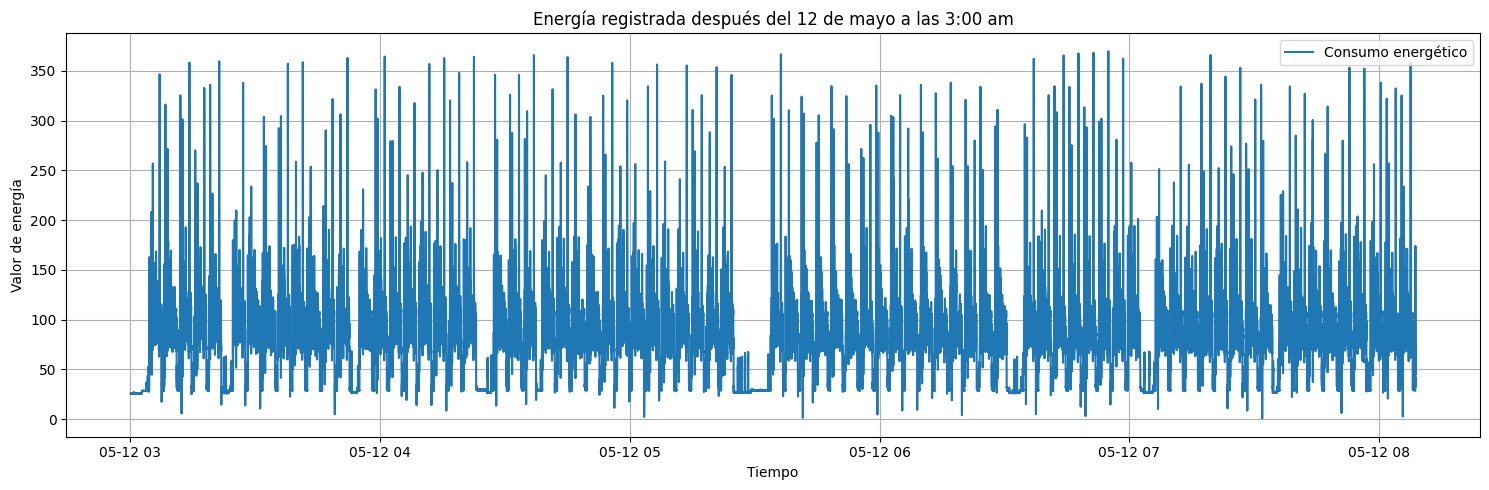

In [235]:
from datetime import datetime

# Filtrar los datos después del 12 de mayo a las 3:00 am

start_time = pd.Timestamp("2025-05-12 03:00:00")
df_after = df_clean[df_clean["timestamp"] > start_time]

plt.figure(figsize=(15, 5))
plt.plot(df_after["timestamp"], df_after["value"], label="Consumo energético")
plt.xlabel("Tiempo")
plt.ylabel("Valor de energía")
plt.title("Energía registrada después del 12 de mayo a las 3:00 am")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

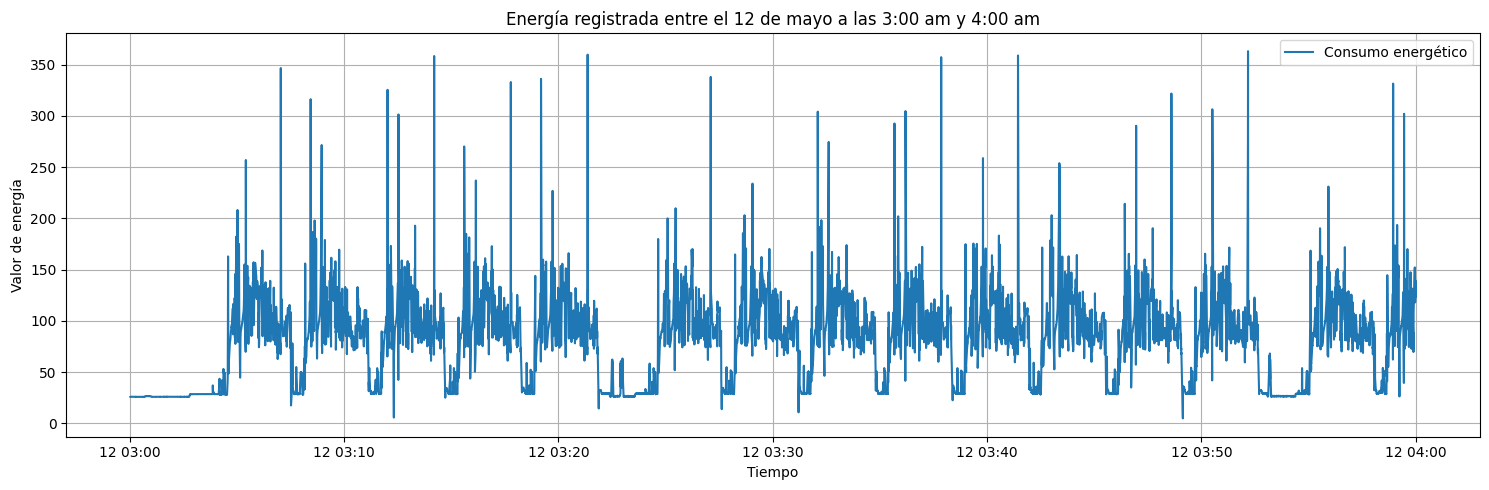

In [236]:
# Filtrar los datos entre las 4:00 am del 12 de mayo y las 4:00 am del 13 de mayo
start = pd.Timestamp("2025-05-12 03:00:00")
end = pd.Timestamp("2025-05-12 04:00:00")
df_3a4 = df_clean[(df_clean["timestamp"] >= start) & (df_clean["timestamp"] < end)]

plt.figure(figsize=(15, 5))
plt.plot(df_3a4["timestamp"], df_3a4["value"], label="Consumo energético")
plt.xlabel("Tiempo")
plt.ylabel("Valor de energía")
plt.title("Energía registrada entre el 12 de mayo a las 3:00 am y 4:00 am")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

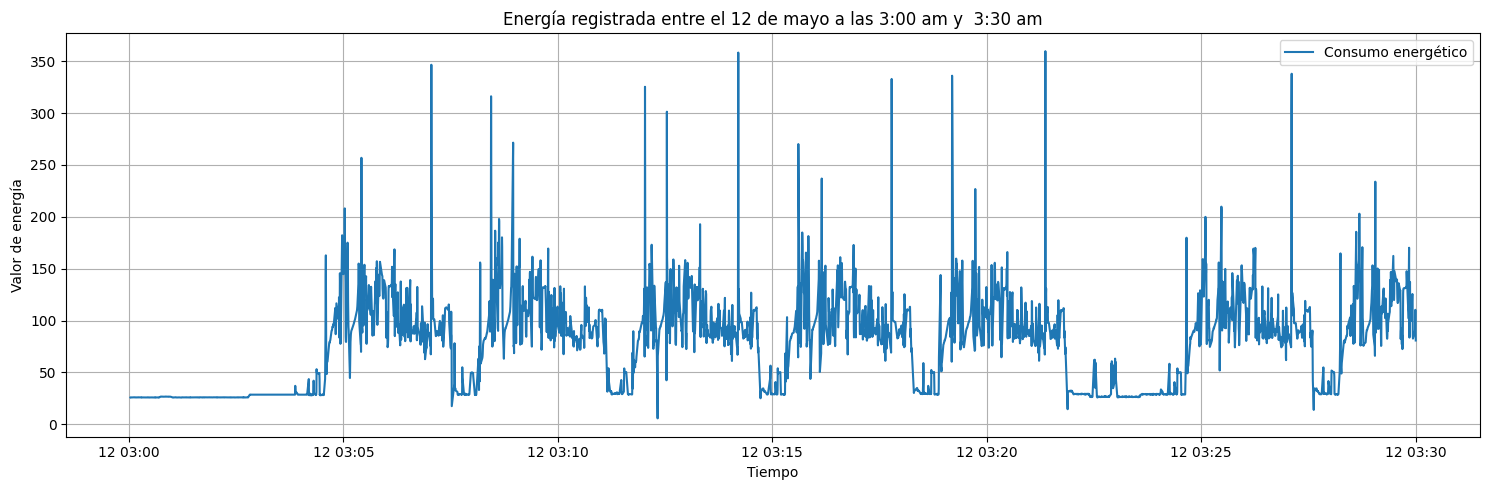

In [237]:
start = pd.Timestamp("2025-05-12 03:00:00")
end = pd.Timestamp("2025-05-12 03:30:00")
df_3a4 = df_clean[(df_clean["timestamp"] >= start) & (df_clean["timestamp"] < end)]

plt.figure(figsize=(15, 5))
plt.plot(df_3a4["timestamp"], df_3a4["value"], label="Consumo energético")
plt.xlabel("Tiempo")
plt.ylabel("Valor de energía")
plt.title("Energía registrada entre el 12 de mayo a las 3:00 am y  3:30 am")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [238]:
from energy_ml.state_detector import StateDetector

detector = StateDetector(df_clean, n_states=3)
df_clustered = detector.classify_states()
df_clustered.head()

g:\My Drive\Documentos Juan Felipe\Technical Assessment\energy_ml_project\energy_ml\state_detector.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["rolling_mean"] = df[self.energy_col].rolling(window, center=True).mean().fillna(method='bfill').fillna(method='ffill')


,timestamp,value,state_cluster
0,2025-05-11 07:08:49.154,25.96,0
1,2025-05-11 07:08:49.413,26.21,0
2,2025-05-11 07:08:49.672,25.99,0
3,2025-05-11 07:08:49.931,25.83,0
4,2025-05-11 07:08:52.017,26.23,0


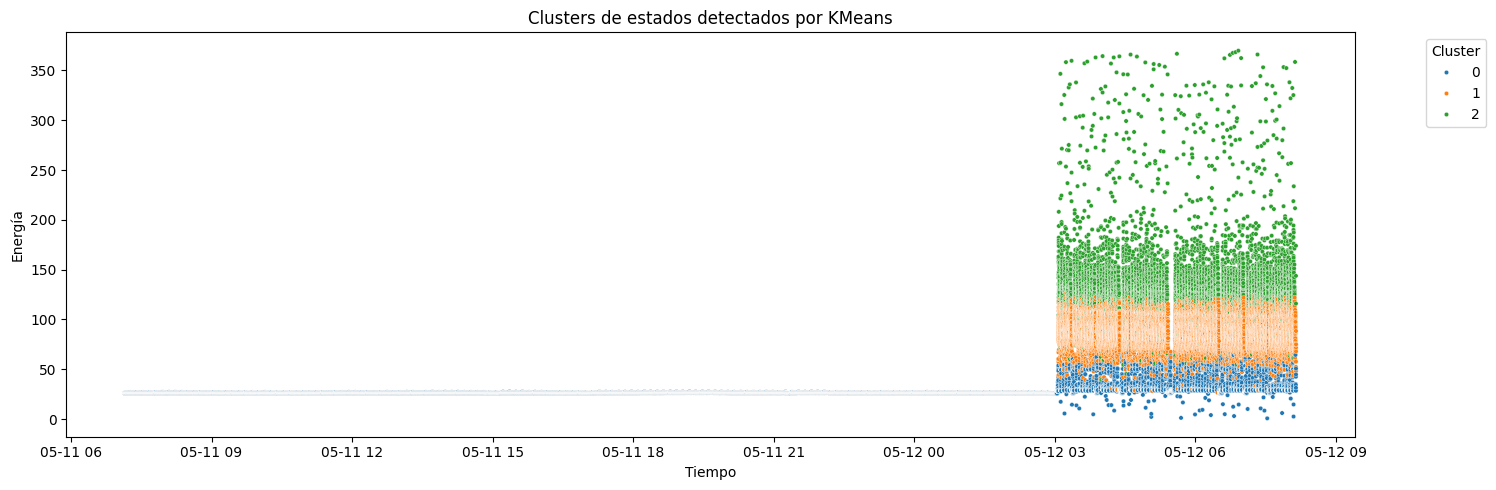

In [239]:
import seaborn as sns

plt.figure(figsize=(15, 5))
sns.scatterplot(data=df_clustered, x="timestamp", y="value", hue="state_cluster", palette="tab10", s=10)
plt.title("Clusters de estados detectados por KMeans")
plt.xlabel("Tiempo")
plt.ylabel("Energía")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


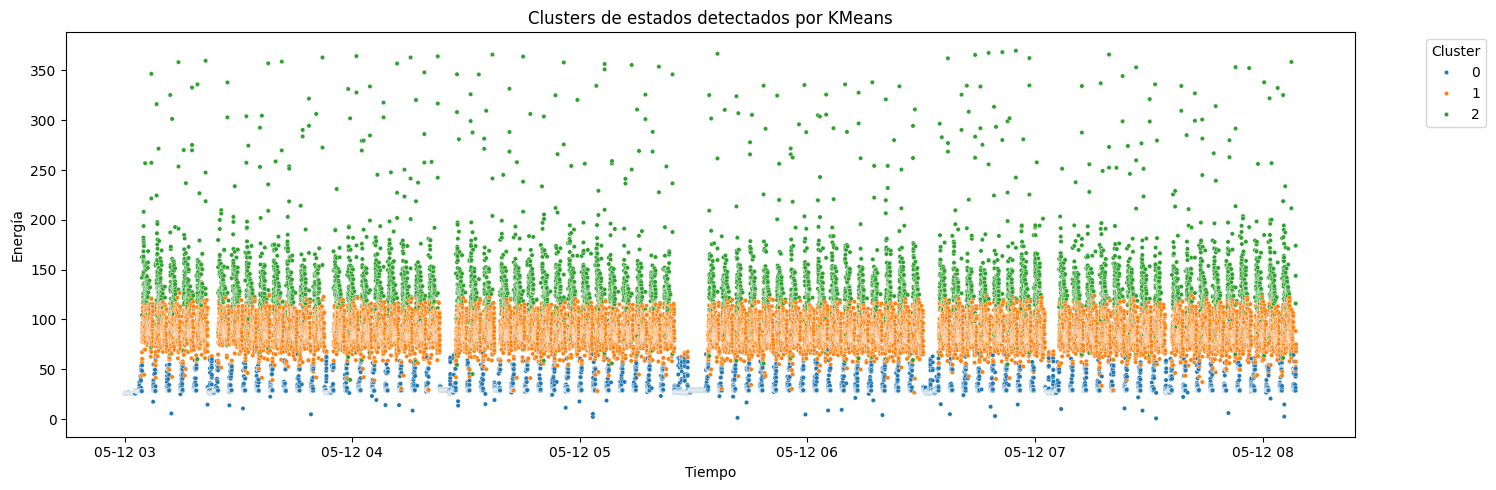

In [240]:
start = pd.Timestamp("2025-05-12 03:00:00")
df_3a4_Clustered = df_clustered[(df_clustered["timestamp"] >= start)]


plt.figure(figsize=(15, 5))
sns.scatterplot(data=df_3a4_Clustered, x="timestamp", y="value", hue="state_cluster", palette="tab10", s=10)
plt.title("Clusters de estados detectados por KMeans")
plt.xlabel("Tiempo")
plt.ylabel("Energía")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


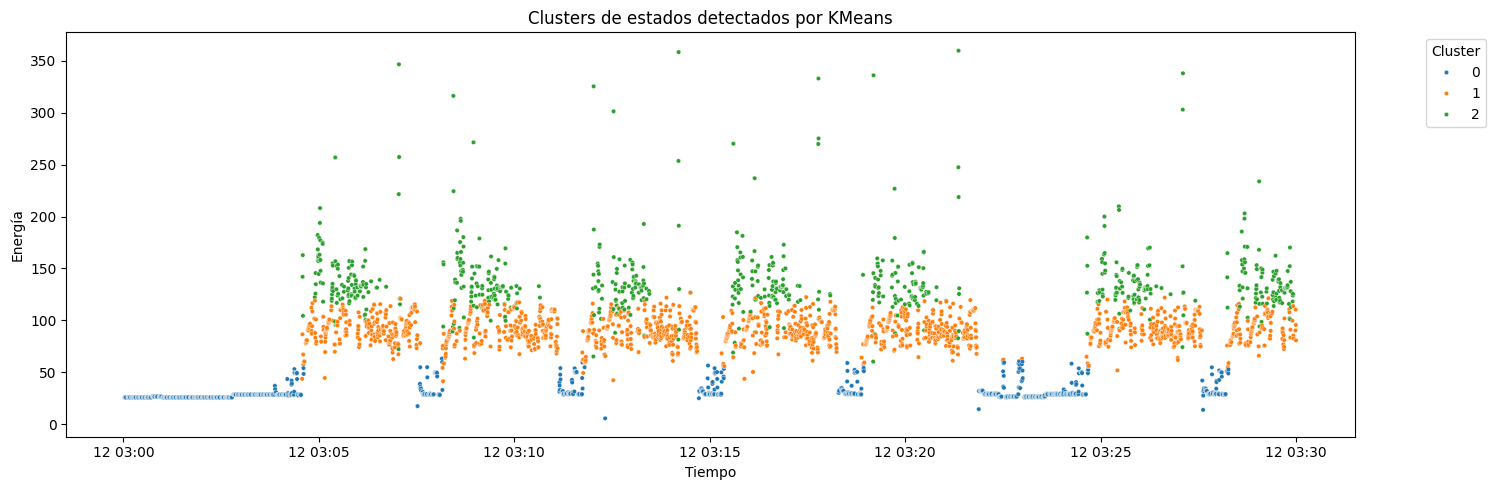

In [241]:
start = pd.Timestamp("2025-05-12 03:00:00")
end = pd.Timestamp("2025-05-12 03:30:00")
df_3a4_Clustered = df_clustered[(df_clustered["timestamp"] >= start) & (df_clustered["timestamp"] < end)]


plt.figure(figsize=(15, 5))
sns.scatterplot(data=df_3a4_Clustered, x="timestamp", y="value", hue="state_cluster", palette="tab10", s=10)
plt.title("Clusters de estados detectados por KMeans")
plt.xlabel("Tiempo")
plt.ylabel("Energía")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


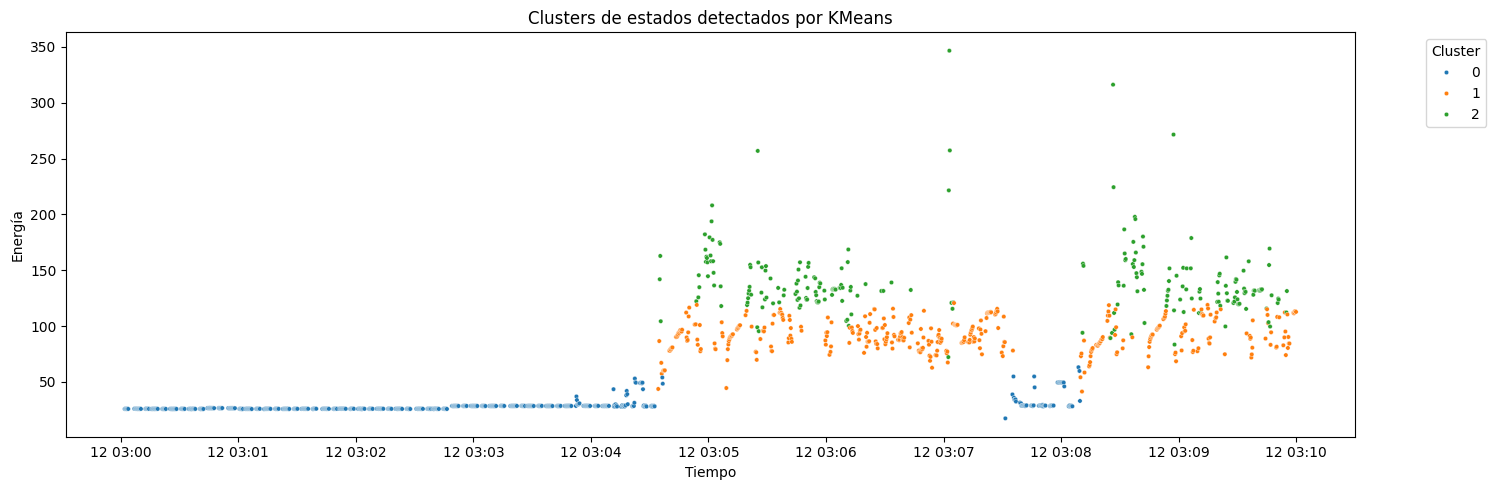

In [242]:
start = pd.Timestamp("2025-05-12 03:00:00")
end = pd.Timestamp("2025-05-12 03:10:00")
df_3a4_Clustered = df_clustered[(df_clustered["timestamp"] >= start) & (df_clustered["timestamp"] < end)]


plt.figure(figsize=(15, 5))
sns.scatterplot(data=df_3a4_Clustered, x="timestamp", y="value", hue="state_cluster", palette="tab10", s=10)
plt.title("Clusters de estados detectados por KMeans")
plt.xlabel("Tiempo")
plt.ylabel("Energía")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [243]:
def segment_product_cycles(df: pd.DataFrame, energy_col: str = "value", threshold: float = 10.0, min_duration: int = 5) -> pd.DataFrame:
    """
    Automatically segment the energy time series into product cycles.

    Parameters:
    - df: Input DataFrame with a time-indexed energy signal.
    - energy_col: Name of the energy signal column.
    - threshold: Minimum energy value to consider the machine 'active'.
    - min_duration: Minimum number of consecutive active points to count as a cycle.

    Returns:
    - A copy of the DataFrame with a new column 'cycle_id' identifying each product cycle.
    """
    df = df.copy()
    df["active"] = df[energy_col] > threshold

    cycle_id = 0
    cycle_ids = []
    in_cycle = False
    duration = 0

    for is_active in df["active"]:
        if is_active:
            if not in_cycle:
                in_cycle = True
                duration = 1
                cycle_id += 1
            else:
                duration += 1
            cycle_ids.append(cycle_id)
        else:
            if in_cycle:
                if duration < min_duration:
                    cycle_id -= 1
                in_cycle = False
            duration = 0
            cycle_ids.append(0)

    df["cycle_id"] = cycle_ids
    df.drop(columns="active", inplace=True)
    return df


In [244]:
segmented_df = segment_product_cycles(df_clustered, energy_col="value", threshold=30.0, min_duration=10)


In [245]:
segmented_df 

,timestamp,value,state_cluster,cycle_id
0,2025-05-11 07:08:49.154,25.96000,0,0
1,2025-05-11 07:08:49.413,26.21000,0,0
2,2025-05-11 07:08:49.672,25.99000,0,0
3,2025-05-11 07:08:49.931,25.83000,0,0
4,2025-05-11 07:08:52.017,26.23000,0,0
...,...,...,...,...
197221,2025-05-12 08:08:45.874,44.79000,0,198
197222,2025-05-12 08:08:48.206,68.00000,1,198
197223,2025-05-12 08:08:48.465,71.90000,1,198
197224,2025-05-12 08:08:48.724,74.51000,1,198


In [246]:
def count_units_by_period(df: pd.DataFrame, time_col: str = "timestamp", freq: str = "1H") -> pd.DataFrame:
    """
    Count number of production cycles per time period.

    Parameters:
    - df: DataFrame with a 'cycle_id' column and timestamp.
    - time_col: Column with timestamps.
    - freq: Resampling frequency (e.g., '1H' for hourly, '1D' for daily).

    Returns:
    - DataFrame with counts of cycles per period.
    """
    df_cycles = df[df["cycle_id"] > 0].drop_duplicates("cycle_id")
    df_cycles[time_col] = pd.to_datetime(df_cycles[time_col])
    df_cycles.set_index(time_col, inplace=True)

    count_by_period = df_cycles.resample(freq)["cycle_id"].count().rename("units_produced").reset_index()
    return count_by_period


In [247]:
units_hourly = count_units_by_period(segmented_df, time_col="timestamp", freq="1H")


C:\Users\ingju\AppData\Local\Temp\ipykernel_41240\4188470063.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  count_by_period = df_cycles.resample(freq)["cycle_id"].count().rename("units_produced").reset_index()


In [251]:
units_hourly

,timestamp,units_produced
0,2025-05-12 03:00:00,38
1,2025-05-12 04:00:00,40
2,2025-05-12 05:00:00,36
3,2025-05-12 06:00:00,40
4,2025-05-12 07:00:00,35
5,2025-05-12 08:00:00,9


In [248]:
def assess_cycle_quality(df: pd.DataFrame, time_col: str = "timestamp", expected_duration: float = None) -> pd.DataFrame:
    """
    Compare cycle durations against a standard and flag anomalies.

    Parameters:
    - df: DataFrame with 'cycle_id' and 'timestamp'.
    - expected_duration: Optional fixed expected duration in seconds.

    Returns:
    - DataFrame with one row per cycle and a 'quality_flag' column.
    """
    df_cycles = df[df["cycle_id"] > 0].groupby("cycle_id").agg(
        start_time=(time_col, "first"),
        end_time=(time_col, "last")
    ).reset_index()

    df_cycles["duration_sec"] = (df_cycles["end_time"] - df_cycles["start_time"]).dt.total_seconds()

    if expected_duration is None:
        expected_duration = df_cycles["duration_sec"].median()

    # Flag if duration is significantly different from expected
    tolerance = 0.4  # 40% deviation is considered anomalous
    df_cycles["quality_flag"] = df_cycles["duration_sec"].apply(
        lambda d: "anomalous" if abs(d - expected_duration) > tolerance * expected_duration else "ok"
    )

    return df_cycles


In [249]:
quality_report = assess_cycle_quality(segmented_df, time_col="timestamp")


In [250]:
quality_report

,cycle_id,start_time,end_time,duration_sec,quality_flag
0,1,2025-05-12 03:03:52.598,2025-05-12 03:04:26.583,33.985,ok
1,2,2025-05-12 03:04:34.360,2025-05-12 03:07:31.279,176.919,anomalous
2,3,2025-05-12 03:07:35.161,2025-05-12 03:07:39.519,4.358,anomalous
3,4,2025-05-12 03:07:46.254,2025-05-12 03:08:01.614,15.360,anomalous
4,5,2025-05-12 03:08:08.852,2025-05-12 03:11:14.636,185.784,anomalous
...,...,...,...,...,...
193,194,2025-05-12 08:04:45.414,2025-05-12 08:05:00.971,15.557,anomalous
194,195,2025-05-12 08:05:06.207,2025-05-12 08:05:40.646,34.439,ok
195,196,2025-05-12 08:05:43.766,2025-05-12 08:08:05.916,142.150,anomalous
196,197,2025-05-12 08:08:09.806,2025-05-12 08:08:36.016,26.210,ok


<Axes: xlabel='quality_flag'>

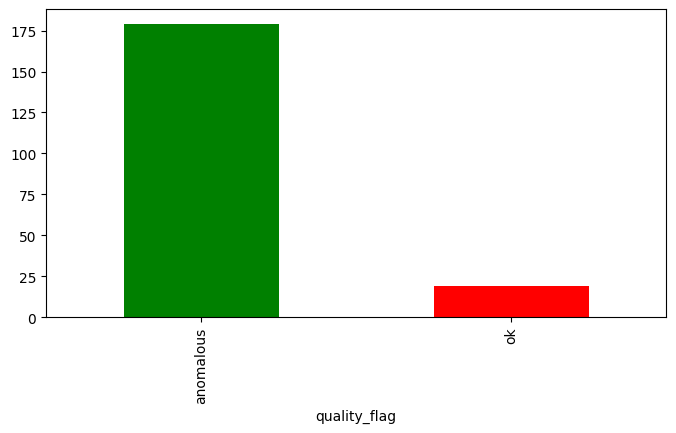

In [252]:
quality_report["quality_flag"].value_counts().plot(kind='bar', figsize=(8, 4), color=['green', 'red'])